## DEMO - Training eines CNN

Verwendung in der Projektphase 2

Das Notebook zeigt beispielhaft die Durchführung folgender Schritte mit Keras:
- Vorverarbeitungsschritte der Bilder
- Trainieren eines CNNs
- Speichern und Laden
- Anwendung
- Transformation in ein TF-lite-Modell

Die verwendeten Bilder befinden sich in `/gitignore/data/images`.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from os import listdir,path
import cv2

In [2]:
# Lesen der Filenamen der Bilder in einem Ordner    
img_path = './bilder_nn/'
img_files = listdir(img_path)
# Testweises Einlesen aller Bilder -> Kontrolle der Anzahl
imgs_test = np.array([cv2.imread(img_path+i) for i in img_files])
imgs_test.shape

(703, 480, 640, 3)

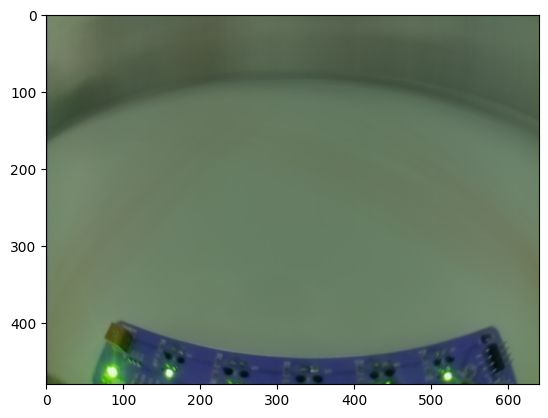

In [3]:
# Mittleres Bilder der Trainingsbilder
img_mean = imgs_test.mean(axis=0).astype('int')
plt.imshow(img_mean)

In [26]:
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image(img):
    dim = (64,48)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) # Verwendung von Graustufenbildern
    img = img[80:380,0:640] # Ausschneiden eines Teilbildes
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    
    return img


# Laden und Vorverarbeiten aller Trainingsbilder
imgs = np.array([transform_image(cv2.imread(img_path+i)) for i in img_files])
imgs.shape


(703, 48, 64, 3)

In [3]:
# Alternative für verkleinert Bilder
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image_small(img):
    dim = (64,48)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) # Verwendung von Graustufenbildern
    img = img[80:380,0:640] # Ausschneiden eines Teilbildes
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    return img

# Laden und Vorverarbeiten aller Trainingsbilder
imgs = np.array([transform_image_small(cv2.imread(img_path+i)) for i in img_files])
imgs.shape


(703, 48, 64, 3)

81.69531975437609
255
0


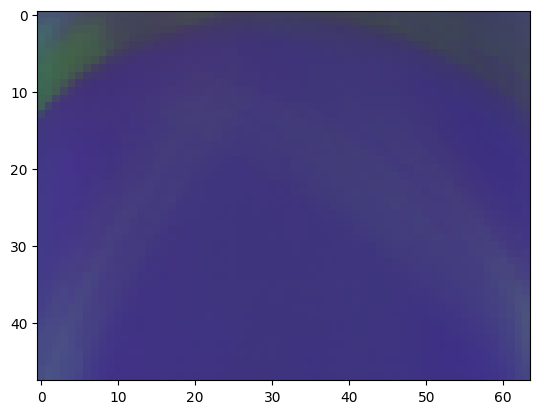

In [4]:
# Mittleres vorverarbeitetes Trainingsbild
plt.imshow(imgs.mean(axis=0).astype('int'),cmap='gray')
print(imgs.mean())
print(imgs.max())
print(imgs.min())

### Spiegeln der Bilder (Augmentation)

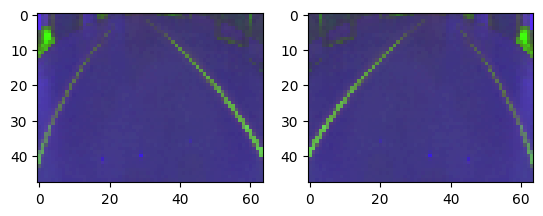

In [5]:
# Test Spiegeln eines vorverarbeiteten Bildes
imgs_mirrored = imgs[:,:,::-1]
plt.figure()
plt.subplot(121)
plt.imshow(imgs[10],cmap='gray')
plt.subplot(122)
plt.imshow(imgs_mirrored[10],cmap='gray')

In [6]:
# Zusammenfügen der ungespiegelten und der gespiegelten Trainingsdaten
print(imgs.shape)
print(imgs_mirrored.shape)
imgs_all = np.concatenate((imgs,imgs_mirrored))   #hier werden die gespiegelten Bilder zusammengefügt
print(imgs_all.shape)

(703, 48, 64, 3)
(703, 48, 64, 3)
(1406, 48, 64, 3)


### "Spiegeln" der Lenkwinkel (Agumentation)
- inklusive des Ladens/Extrahierens der Lenkwinkel aus den Dateinamen

In [7]:
# Position des Lenkwinkels im Filenamen (abhängig vom OS!)
wert = 45
print(img_files[wert])
print(img_files[wert][29:-4]) # Raspberry/Linux
##print('-',i[50:-4],'-') # Windows


Bild 2023-09-28 095257_Angle_120.png
120


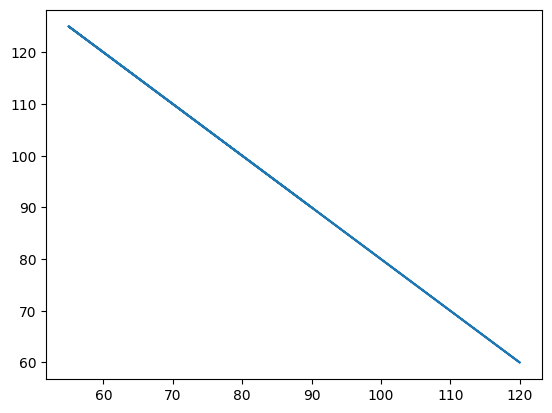

In [8]:
angles = np.array([int(i[29:-4]) for i in img_files]) # Extrahieren der Lenkwinkel aus dem Dateinamen
angles_mirrored = [-(a-90)+90 for a in angles] # Spiegeln der Winkel

# Kontrolle
plt.plot(angles,angles_mirrored)
angles_all = np.hstack((angles,angles_mirrored)) # Zusammenführen der ungespiegelten und gespiegelten Winkel

### Verteilung der Lenkwinkel

<AxesSubplot:>

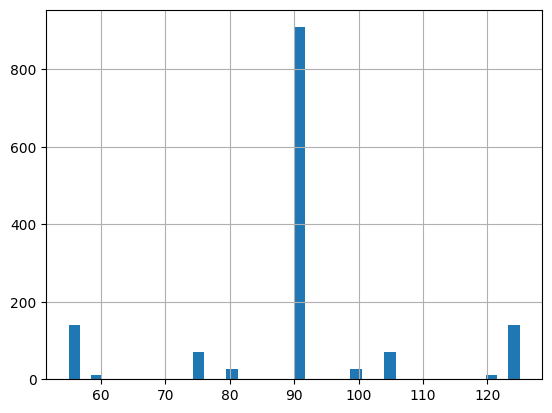

In [9]:
pd.Series(angles_all, name ='angles').hist(bins = 40)

### Einteilen der Trainingsdaten

In [10]:
# Split Trainings- und Testdaten
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(imgs_all, angles_all, test_size = 0.2, random_state = 1)

### Erstellen des NN  mit Tensorflow

In [11]:
# Korntrolle
print(X_train.dtype)
print(X_train.shape)
print(y_train.shape)
print(X_validate.dtype)
print(X_validate.shape)
print(X_validate.shape)

uint8
(1124, 48, 64, 3)
(1124,)
uint8
(282, 48, 64, 3)
(282, 48, 64, 3)


In [12]:
# Import notwendiger Klassen und Funktionen
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam

In [13]:
# Kontrolle bzw. Ermitteln des Shape der Eingabedaten/Inputshape
n,h,w,f=imgs_all.shape
input_shape = (h,w,f)
print(input_shape)

(48, 64, 3)


In [ ]:
# Erstellen des Netzes
# Keras Sequntial API
model = tf.keras.Sequential(name='dnn') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # more robustness 
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers 
model.add(Flatten()) 
model.add(Dropout(0.2)) # more robustness 
##model.add(Dense(100, activation='elu')) 
model.add(Dense(50, activation='elu')) 
model.add(Dense(10, activation='elu'))

# Output Layer: turning angle
model.add(Dense(1)) 


In [14]:
# Alternative für kleiens Bild
# Erstellen des Netzes für das stark verkleinert Bild

n, h, w, f = imgs_all.shape
input_shape = (h, w, f)
print(input_shape)
# Keras Sequntial API
model_small = tf.keras.Sequential(name='dnn_small')

# Convolution Layers
# elu: Expenential Linear Unit, similar to leaky Relu
model_small.add(Conv2D(10, (3, 3), strides=(2, 2),
                input_shape=input_shape, activation='elu'))
model_small.add(Conv2D(20, (2, 2), strides=(2, 2), activation='elu'))
model_small.add(Conv2D(40, (2, 2), strides=(2, 2), activation='elu'))

# Fully Connected Layers
model_small.add(Flatten())
model_small.add(Dropout(0.2))  # more robustness
model_small.add(Dense(5, activation='elu'))
model_small.add(Dense(5, activation='elu'))

# Output Layer: turning angle
model_small.add(Dense(1))

(48, 64, 3)


In [16]:
# Kontrolle der Architektur
model_small.summary()

Model: "dnn_small"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 31, 10)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 15, 20)        820       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 7, 40)          3240      
_________________________________________________________________
flatten (Flatten)            (None, 1400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1400)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7005      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30

### Trainieren des NN

In [17]:
# Kompiliern des Modells und Wahl von Fehlerfunktion und Optimizer
model_small.compile(loss ='mse', optimizer=Adam(lr=0.001))

In [18]:
# Training
history = model_small.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs= 35,
    verbose=1,
    validation_data=(X_validate,y_validate)
)

2023-09-29 10:28:48.957873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-29 10:28:48.959138: W tensorflow/core/platform/profile_utils/cpu_utils.cc:116] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


Epoch 1/35
36/36 [==============================] - 14s 179ms/step - loss: 1202.3005 - val_loss: 293.9384
Epoch 2/35
36/36 [==============================] - 4s 121ms/step - loss: 295.4420 - val_loss: 201.3176
Epoch 3/35
36/36 [==============================] - 5s 129ms/step - loss: 214.3234 - val_loss: 81.4802
Epoch 4/35
36/36 [==============================] - 5s 129ms/step - loss: 124.8262 - val_loss: 73.0179
Epoch 5/35
36/36 [==============================] - 5s 153ms/step - loss: 113.9555 - val_loss: 67.0590
Epoch 6/35
36/36 [==============================] - 5s 141ms/step - loss: 95.1492 - val_loss: 68.5368
Epoch 7/35
36/36 [==============================] - 5s 138ms/step - loss: 91.9207 - val_loss: 64.8519
Epoch 8/35
36/36 [==============================] - 4s 117ms/step - loss: 87.7018 - val_loss: 51.9251
Epoch 9/35
36/36 [==============================] - 5s 147ms/step - loss: 73.0520 - val_loss: 54.2525
Epoch 10/35
36/36 [==============================] - 5s 137ms/step - loss

In [19]:
def train_loss_acc_plot(history,skip=0):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'][skip:], label='Loss')
    plt.plot(history.history['val_loss'][skip:], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

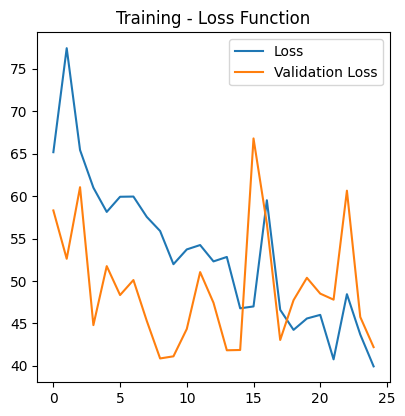

In [20]:
# Begutachtung des Trainingsverlaufs
train_loss_acc_plot(history,skip=10)

In [ ]:
### Eventuelle weiteres Training
##history = model.fit(
##    X_train,
##    y_train,
##    batch_size=200,
##    epochs= 10,
##    verbose=1,
##    validation_split=.3
##)

In [21]:
# Trainings- und Testfehler
mse_train = model_small.evaluate(X_train,y_train)
mse_validate = model_small.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

9/9 [==============================] - 1s 50ms/step - loss: 42.2162
MSE train/val: 25.1209 / 42.2162
RMSE train/val: 5.0121 / 6.4974


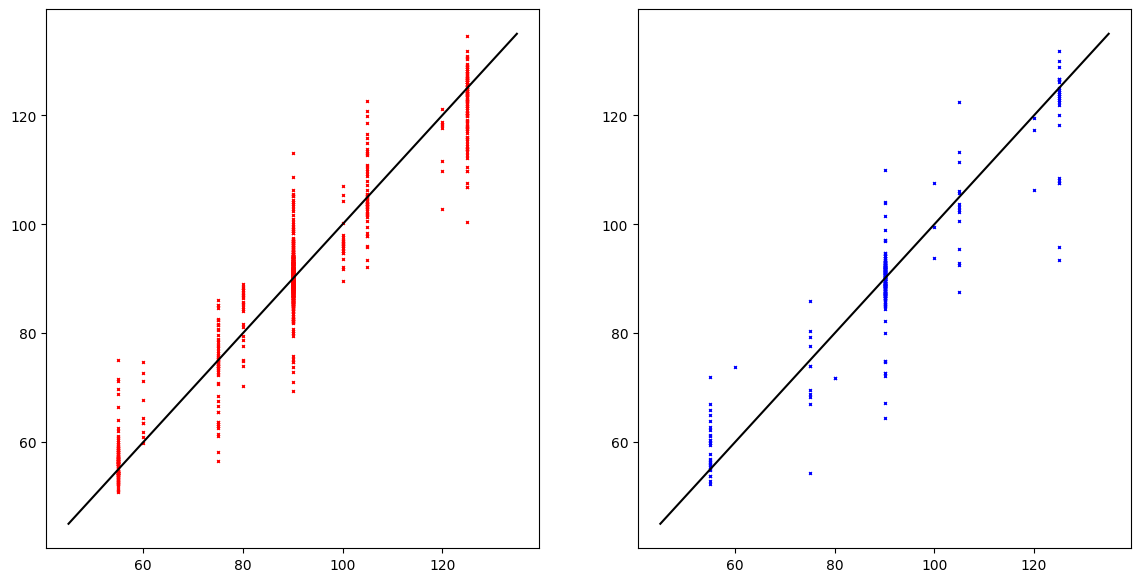

In [22]:
# Visualisierung der Fehler
y_train_p = model_small.predict(X_train)
y_validate_p = model_small.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

In [23]:
# Speichern des trainierten Modells
#path_to_model_file = './DEMO_MODEL.h5'# Speichert im H5-Format
path_to_model_file = './DEMO_MODEL' # Speichert im SavedModel-Format
model_small.save(path_to_model_file)

2023-09-29 10:34:30.424405: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./DEMO_MODEL/assets


## Verwendung eines trainierten Modells

In [24]:
# Laden eines Modells
path_to_model_file = './DEMO_MODEL'
model_loaded = tf.keras.models.load_model(path_to_model_file)

In [25]:
# Shape des Input-Layers
model_loaded.layers[0].input_shape

(None, 48, 64, 3)

In [26]:
mse_train = model_loaded.evaluate(X_train,y_train)
mse_validate = model_loaded.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate))) # abweichung in grad

9/9 [==============================] - 1s 52ms/step - loss: 42.2162
MSE train/val: 25.1209 / 42.2162
RMSE train/val: 5.0121 / 6.4974


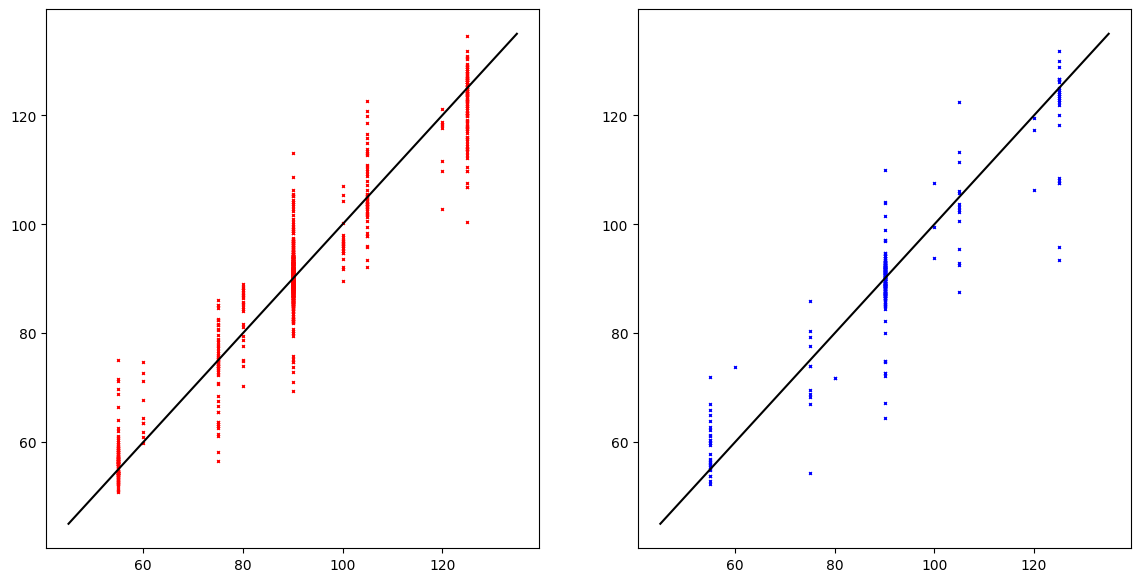

In [27]:
# Visualisierung der Fehler
y_train_p = model_loaded.predict(X_train)
y_validate_p = model_loaded.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

### Anwendung des Netzes zur Bestimmung des Lenkwinkels

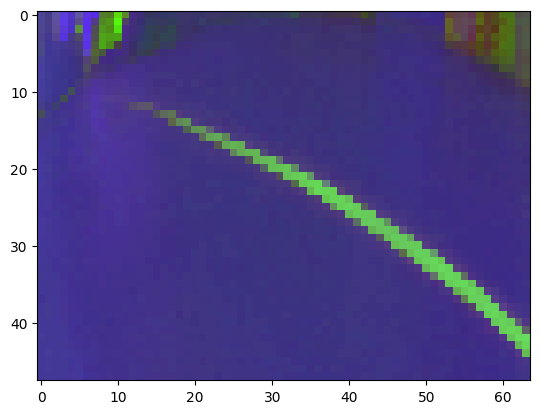

In [33]:
# Wahl eines Beispielbildes!
wert = 11
xe = np.array( [X_train[wert]] )
xe.shape
plt.imshow(X_train[wert])

In [34]:
# Mittels der Methode __call__ 
model_loaded(xe).numpy()

array([[52.222748]], dtype=float32)